# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the [private link](https://www.kaggle.com/t/f198351e92ff46d5a839fd73d22e9cbc).

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score.

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models.

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95%

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard.

# Dataset Preparation
___

1.  Download [`dataset.zip`](https://cs.nyu.edu/~fergus/teaching/vision/dataset.zip) from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`.
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it.
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested.


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd  /content/drive/'MyDrive'/cv_kaggle_assignment/

Mounted at /content/drive
/content/drive/MyDrive/cv_kaggle_assignment


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataloader

In [ ]:

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt", transform=None):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
        self.transform = transform

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y



train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 64
momentum = 0.9
lr = 0.001
epochs = 300
log_interval = 100

# Create DataLoader with data augmentation
train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)



# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34, vgg16

nclasses = 43 # GTSRB has 43 classes



class VGGNet(nn.Module):
    def __init__(self, n_out=43, dropout_prob=0.5):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, n_out)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x




# Training

In [ ]:
from torch.optim.adam import Adam
model = VGGNet().to(device)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

best_validation_accuracy = 0.0
best_model_file = None

train_accuracy_values = []

def train(epoch):
    global best_validation_accuracy
    correct = 0
    total = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # Calculate training accuracy
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_accuracy = 100. * correct / total
    print('Train Epoch: {}\tTraining Accuracy: {:.2f}%'.format(epoch, train_accuracy))

    # Append the training accuracy to the list
    train_accuracy_values.append(train_accuracy)



def validation():
    global best_validation_accuracy  # Declare as global
    global best_model_file
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        # validation_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    validation_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))
    accuracy = 100. * correct / len(val_loader.dataset)

    if accuracy > best_validation_accuracy:
      best_validation_accuracy = accuracy
      best_model_file = 'best_model.pth'
      torch.save(model.state_dict(), best_model_file)
      print('Saved best model with validation accuracy: {:.2f}%'.format(accuracy))




for epoch in range(1, 301):
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')



print('\nTraining completed.')

# Load the best model weights
if best_model_file is not None:
    model.load_state_dict(torch.load(best_model_file))
    print('Loaded the best model with validation accuracy: {:.2f}%'.format(best_validation_accuracy))



Train Epoch: 1 [0/35339 (0%)]	Loss: 3.831787
Train Epoch: 1 [6400/35339 (18%)]	Loss: 3.327413
Train Epoch: 1 [12800/35339 (36%)]	Loss: 3.043579
Train Epoch: 1 [19200/35339 (54%)]	Loss: 2.550018
Train Epoch: 1 [25600/35339 (72%)]	Loss: 2.125697
Train Epoch: 1 [32000/35339 (90%)]	Loss: 1.958508
Train Epoch: 1	Training Accuracy: 20.05%

Validation set: Average loss: 2.5884, Accuracy: 678/3870 (18%)

Saved best model with validation accuracy: 17.52%

Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 2.330788
Train Epoch: 2 [6400/35339 (18%)]	Loss: 2.155135
Train Epoch: 2 [12800/35339 (36%)]	Loss: 1.999758
Train Epoch: 2 [19200/35339 (54%)]	Loss: 1.932883
Train Epoch: 2 [25600/35339 (72%)]	Loss: 1.929916
Train Epoch: 2 [32000/35339 (90%)]	Loss: 1.716706
Train Epoch: 2	Training Accuracy: 37.42%

Validation set: Average loss: 2.2692, Accuracy: 984/3870 (25%)

Saved best model with validation accuracy: 25.43%

Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 1.8494

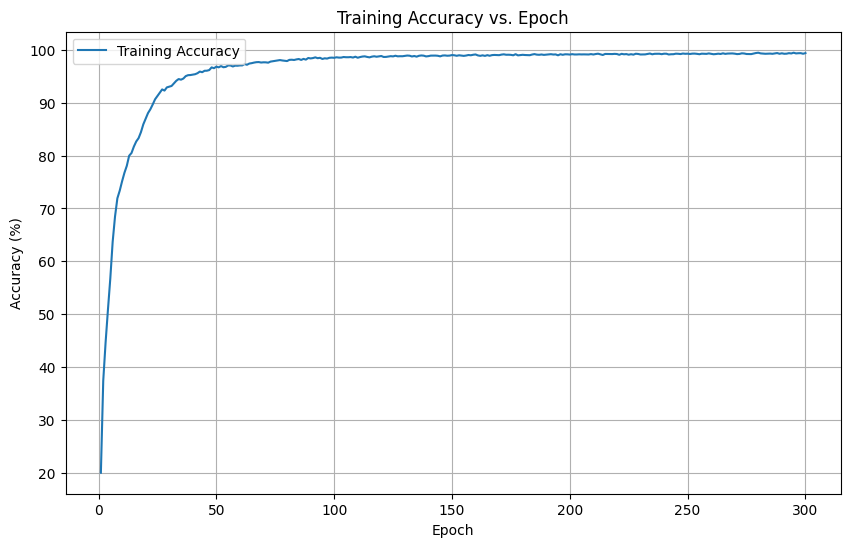

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if best_model_file is not None:
  model = VGGNet().to(device)
  model.load_state_dict(torch.load('/content/drive/MyDrive/cv_kaggle_assignment/best_model.pth', map_location=torch.device('cpu')))
  print('Loaded the best model with validation accuracy: {:.2f}%'.format(best_validation_accuracy))

Loaded the best model with validation accuracy: 97.93%


I explored multiple architecures like resnet18, resnet34 and VGG16, with various combination of hyperparameters. The chosen model is based on the VGG16-net architecture since it is a much deeper architecture helping the model to train better.

I explored the paper **Dropout-VGG Based Convolutional Neural Network for Traffic Sign Categorization** and tried to implement a similar model. The only drawback of using such a architecture was that, the training was very slow.

# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(test_data):
    data = data.unsqueeze(0).to(device)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

**Extra important:** Please use your NYU NetID as your team name on Kaggle, or your submissions will not be evaluated.  
You can rename your team easily from the Team tab: https://www.kaggle.com/competitions/nyu-computer-vision-csci-ga2271-2022/team.